In [1]:
#Import all relevant packages
import numpy as np
import torch
import torch.nn as nn
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import matplotlib.pyplot as plt
from PIL import Image
import tqdm.notebook as tqdm
import librosa
import pathlib
import skimage as ski
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from IPython.display import Image

import models_mae
from SinexC_algorithm import SinexC_AUDIO_MAE
from spectogram_functions import wav2fbank, norm_fbank
from Masks import MaskGenerator
from RELAX_upsampled_grid import RELAX_upsampled_grid
from plot_function import ALL_plot_AUDIO_MAE
from RELAX import RELAX
%matplotlib inline

# Explainer-notebook for Audio-MAE

In order to use the model you first need to download the files [finetuned.pth](https://drive.google.com/file/d/18EsFOyZYvBYHkJ7_n7JFFWbj6crz01gq/view) and [pretrained.pth](https://drive.google.com/file/d/1ni_DV4dRf7GxM8k-Eirx71WP9Gg89wwu/view) and put them in a folder called `checkpoints` (The files are to big to be uploaded to our github).

#### Next step is to load one of the checkpoint files to the model:

In [2]:
# Path stuff added to make the loading work
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

chkpt_fine = r"./checkpoints/finetuned.pth"
chkpt_pre = r"./checkpoints/pretrained.pth"

# Make models
model_fine = getattr(models_mae, 'mae_vit_base_patch16')(in_chans=1, audio_exp=True,img_size=(1024,128))
model_pre = getattr(models_mae, 'mae_vit_base_patch16')(in_chans=1, audio_exp=True,img_size=(1024,128))

# load checkpoints to models
checkpoint_fine = torch.load(chkpt_fine, map_location='cpu')
msg_fine = model_fine.load_state_dict(checkpoint_fine['model'], strict=False) #Load parameters to model

checkpoint_pre = torch.load(chkpt_pre, map_location='cpu')
msg_pre = model_pre.load_state_dict(checkpoint_pre['model'], strict=False) #Load parameters to model

#### Next we check if the model produces resonable embeddings. We do this by training a linear classifier on the embeddings from the model. 

###### The dataset we test on is [freefield1010](https://www.kaggle.com/datasets/raghaw/freefield1010/data)

In [ ]:
# Load file-paths (both .wav and .json dict with info about the file)
wav_paths = []
json_paths = []
with os.scandir(r"./freefield1010") as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('.wav'):
            wav_paths.append(entry.path)
        if entry.is_file() and entry.name.endswith('.json'):
            json_paths.append(entry.path)

In [ ]:
# Load the data into AUDIO-MAE format (list of pytorch tensors) and labels as a list of 0 or 1 (1 == bird):
N = 100
audio_data = []
labels = []

i = 0
yes_counter = 0
while yes_counter < N:
    with open(json_paths[i], 'r') as f:
        data = json.load(f)
    if 'bird' in data['tags'] or 'birds' in data['tags']:
        audio_wavs = wav2fbank(wav_paths[i])
        audio_wavs = norm_fbank(audio_wavs).unsqueeze(0).unsqueeze(0)
        audio_data.append(audio_wavs)
        labels.append(1)
        yes_counter += 1
    i += 1
      
i = 0
no_counter = 0
while no_counter < N:
    with open(json_paths[i], 'r') as f:
        data = json.load(f)
    if 'bird' not in data['tags'] and 'birds' not in data['tags']:
        audio_wavs = wav2fbank(wav_paths[i])
        audio_wavs = norm_fbank(audio_wavs).unsqueeze(0).unsqueeze(0)
        audio_data.append(audio_wavs)
        labels.append(0)
        no_counter += 1
    i += 1

In [ ]:
# Use model to make embeddings
embeddings = []
for i in tqdm.trange(2*N, desc=f"Makign embeddings for AUDIO-MAE"):
    #emb = model_pre.forward_encoder_no_mask(audio_data[i])[:,0,:].squeeze(0).detach().numpy()
    emb = model_fine.forward_encoder_no_mask(audio_data[i])[:,0,:].squeeze(0).detach().numpy()
    embeddings.append(emb)

#### Then we train a linear classifier (logistic regression) from the embeddings

In [ ]:
X = np.array(embeddings) #Audio input
y = np.array(labels) # Create labels (1 for bird, 0 for not bird)

acc = []
for i in range(100):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=i)

    # Initialize and train the linear classifier
    classifier = LogisticRegression(max_iter=5000)
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate and print the accuracy
    acc.append(accuracy_score(y_test, y_pred))

accuracy = np.mean(acc)
print(f"Accuracy: {accuracy:.2f}")

With a mean accuracy of XXX we asses that the embedding from the model works as intended, the model is not trained speciffically for this task so this is just to test whether or not the embeddings preserves information, which we then conclude that it does.

#### Another sanity check is to plot the PCA of the embeddings, which is done below.

Again the results does not show a clear division, but there is a tendency of the bird-audio to be in the upper left corner and the no-bird audio to be in the lower right corner, so again we asses that the embeddings work as intended.

In [ ]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(np.array(embeddings))

# Plotting
plt.figure(figsize=(8, 4))
plt.scatter(pca_fit[:N, 0], pca_fit[:N, 1], c='blue', label='Bird')
plt.scatter(pca_fit[N:, 0], pca_fit[N:, 1], c='red', label='Not Bird')
plt.legend()
plt.title('PCA Visualization of Audio Embeddings')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

## Now we want to test the RELAX algorithm

To have a baseline to compare the results we use a simple audio-file `whale.wav` of some whale song to compare the results. The spectogram of this audio is plottet below. Furthermore, we need some ways of masking the input data. Below we have plottet examples of two different random masking strategies and one based on image segmentation (Felzenswalp).

In [ ]:
# Input data
wav_file = r"whale.mp3"
fbank = wav2fbank(wav_file)
x = norm_fbank(fbank)
x_min = x.min()
x[650:,:] = x_min

mask_gen_tf = MaskGenerator((1024, 128), mask_type="time+frequency", mask_percentage=50, mask_bs=10)
mask_tf = mask_gen_tf.generate()
mask_gen_RELAX = MaskGenerator((1024, 128), mask_type="RELAX", mask_percentage=50, mask_bs=10)
mask_RELAX = mask_gen_RELAX.generate()

Felz_seq = ski.segmentation.felzenszwalb(x, scale=50, sigma=1.5, min_size=200)
boundaries = ski.segmentation.mark_boundaries(x.detach().numpy(), Felz_seq)
boundaries_clipped = np.clip(boundaries, -1, 1)
print('Number of segments in Felzenswalp segmentation:', np.unique(Felz_seq).shape[0])

fig = plt.figure(figsize=(10, 2.8)) #[left, bottom, width, height]

ax1 = fig.add_axes([0, 1, 1, 1])
ax2 = fig.add_axes([0, 0, 0.5, 0.65])
ax3 = fig.add_axes([0.5, 0, 0.5, 0.65])
ax4 = fig.add_axes([0, 0.52, 1, 0.88])
ax = [ax1, ax2, ax3, ax4]

ax1.imshow(x.T, origin='lower')
ax1.set_title('Benchmark spectrogram (Whale song)')
ax1.set_xticks([]), ax1.set_yticks([])
aspect = 3
ax2.imshow(mask_tf[0].T, origin='lower', aspect=aspect, cmap='Purples')
ax3.imshow(abs(mask_RELAX[0]-1).T, origin='lower', aspect=aspect, cmap='Purples')
ax4.imshow(x[:].T, origin='lower')
ax4.imshow(boundaries[:,:,0].T, origin='lower', alpha=0.8)
ax2.set_xticks([]), ax2.set_yticks([])
ax3.set_xticks([]), ax3.set_yticks([])
ax4.set_xticks([]), ax4.set_yticks([])
ax4.set_title('Felzenszwalb segmentation')
ax2.set_title('Time+Frequency mask')
ax3.set_title('Up-sampled grid mask')
plt.show()

## First we test the up-sampled grid mask used in the RELAX paper

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Input data
wav_file = r"whale.mp3"
fbank = wav2fbank(wav_file)
x = norm_fbank(fbank)
x_min = x.min()
x[650:,:] = x_min
x = x.unsqueeze(0).unsqueeze(0).to(device) #Make x the right dimensions for Audio-MAE

# Small example to illustrate use (To get real results we need many iterations which takes a long time)
R, U = RELAX_upsampled_grid(x, model_fine, mask_bs = 5, num_batches = 2, mask_percentage = 50)

#Make plot containing: heatmap of R and U, insertion/deletion plot from importance matrix (R)
fig, ax = ALL_plot_AUDIO_MAE(R, U, model_fine, x)

### Below the results of the RELAX algorithm with the upsampled-grid masks are shown for mask_bs=50 and num_batches=400

In [ ]:
Image("./plots/RELAX maskbs_50 numbatches_400.png")

# Next we test the time+frequency masks with the RELAX algorithm

Processing batches (uncertainty): 100%|██████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


Processing pixels for AUDIO-MAE:   0%|          | 0/128 [00:00<?, ?it/s]

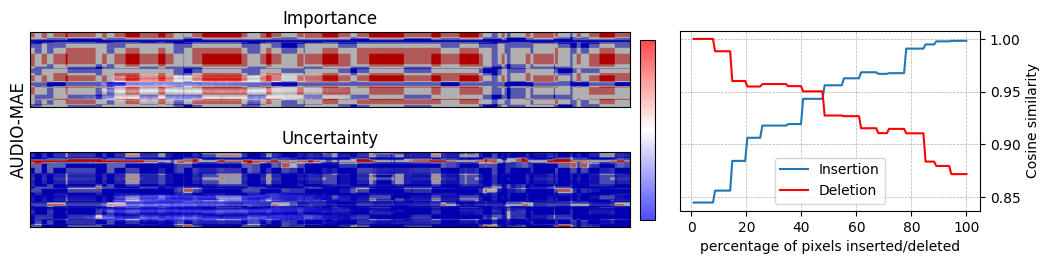

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Input data
wav_file = r"whale.mp3"
fbank = wav2fbank(wav_file)
x = norm_fbank(fbank)
x_min = x.min()
x[650:,:] = x_min
x = x.unsqueeze(0).unsqueeze(0).to(device) #Make x the right dimensions for Audio-MAE


R, U = RELAX(x, model_fine, mask_bs=2, num_batches=2, mask_percentage=50, mask_type = 'time+frequency',
            freq_patch = 8, time_patch = 32)

#Make plot containing: heatmap of R and U, insertion/deletion plot from importance matrix (R)
fig, ax = ALL_plot_AUDIO_MAE(R, U, model_fine, x)

### Below the results of the RELAX algorithm with the time+frequency masks are shown for mask_bs=50 and num_batches=400

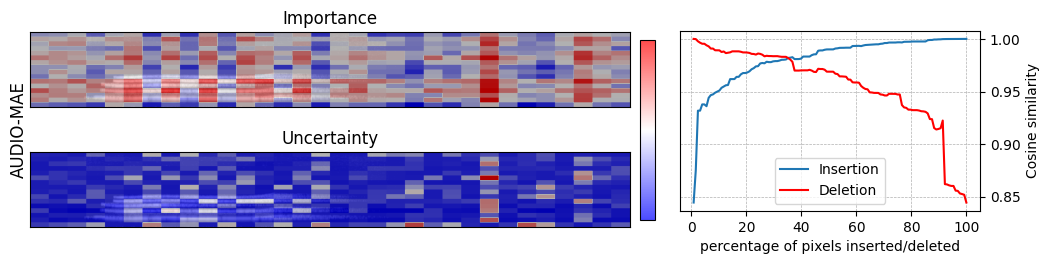

In [8]:
Image("./plots/time+freq_50percent_8x32_50x400.png")

# Next we test the SINEXC inspired algorithm

Number of segments from the Felzenswalp segmentation: 34


Processing segments for AUDIO-MAE: 100%|███████████████████████████████████████████████| 34/34 [00:41<00:00,  1.22s/it]


Processing pixels for AUDIO-MAE:   0%|          | 0/128 [00:00<?, ?it/s]

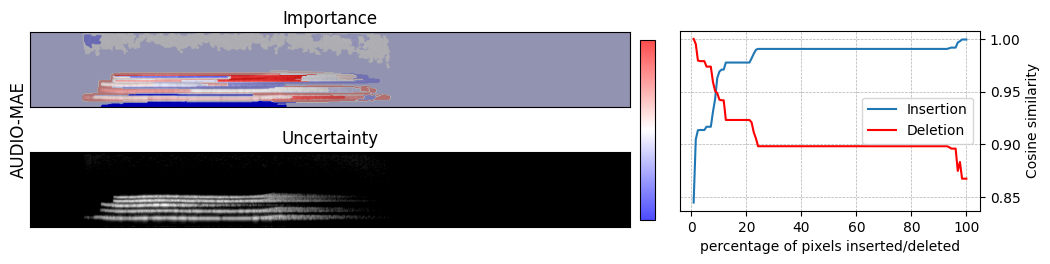

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Input data
wav_file = r"whale.mp3"
fbank = wav2fbank(wav_file)
x = norm_fbank(fbank)
x_min = x.min()
x[650:,:] = x_min
x = x.unsqueeze(0).unsqueeze(0).to(device) #Make x the right dimensions for Audio-MAE

Felz_seq = ski.segmentation.felzenszwalb(x[0,0,:,:].to('cpu'), scale=50, sigma=1.5, min_size=200)
num_segments = np.unique(Felz_seq).shape[0]
print('Number of segments from the Felzenswalp segmentation:', num_segments)

R, U = SinexC_AUDIO_MAE(Felz_seq, model_fine, x, alpha=1, beta=0.2)

fig, ax = ALL_plot_AUDIO_MAE(R, U, model_fine, x.to(device))

## Below is the results of the SINEXC inspired algorithm are shown with $\alpha=50$ and $\beta=0.2$

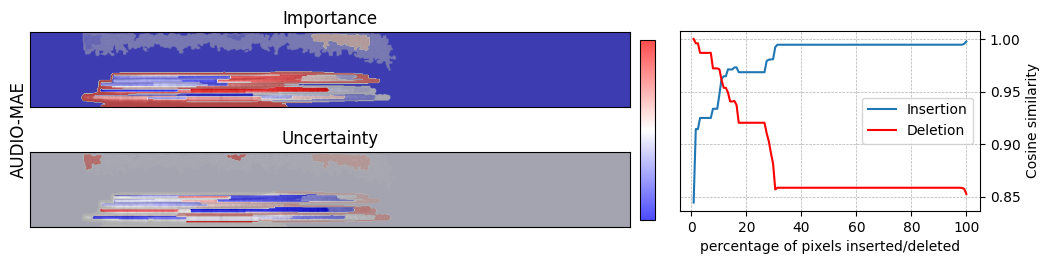

In [13]:
Image("./plots/Felz_minsize_200_alpha50_beta0.20.png")

# Next we test the performance on some noisy input data